# Cleaning the graph

This notebook demonstrate the usage of the main functions for cleaning and fixing topological errors in the `GeoDataFrame` representing the nodes and the edges of the street network.

In [1]:
import cityImage as ci
import pandas as pd
import geopandas as gpd

%matplotlib inline

In [2]:
# initialise path, names, etc.
epsg = 3003
crs = 'EPSG:'+str(epsg)
place = 'Rivoli, Italy'

Choose between the following methods:

* `OSMplace`, providing an OSM place name (e.g. City).
* `polygon`, providing a Polygon (coordinates must be in units of latitude-longitude degrees).
* `distance_from_address`, providing a precise address and setting the `distance` parameter.
* `distance_from_point`, providing point coordinates (in units of latitude-longitude degrees) and setting the `distance` parameter to build the bounding box around the point.

In [3]:
download_method = 'distance_from_address'
nodes_graph, edges_graph = ci.get_network_fromOSM(place = place, download_method = download_method, network_type = 'walk',
                                                  distance = 2000, epsg = epsg)

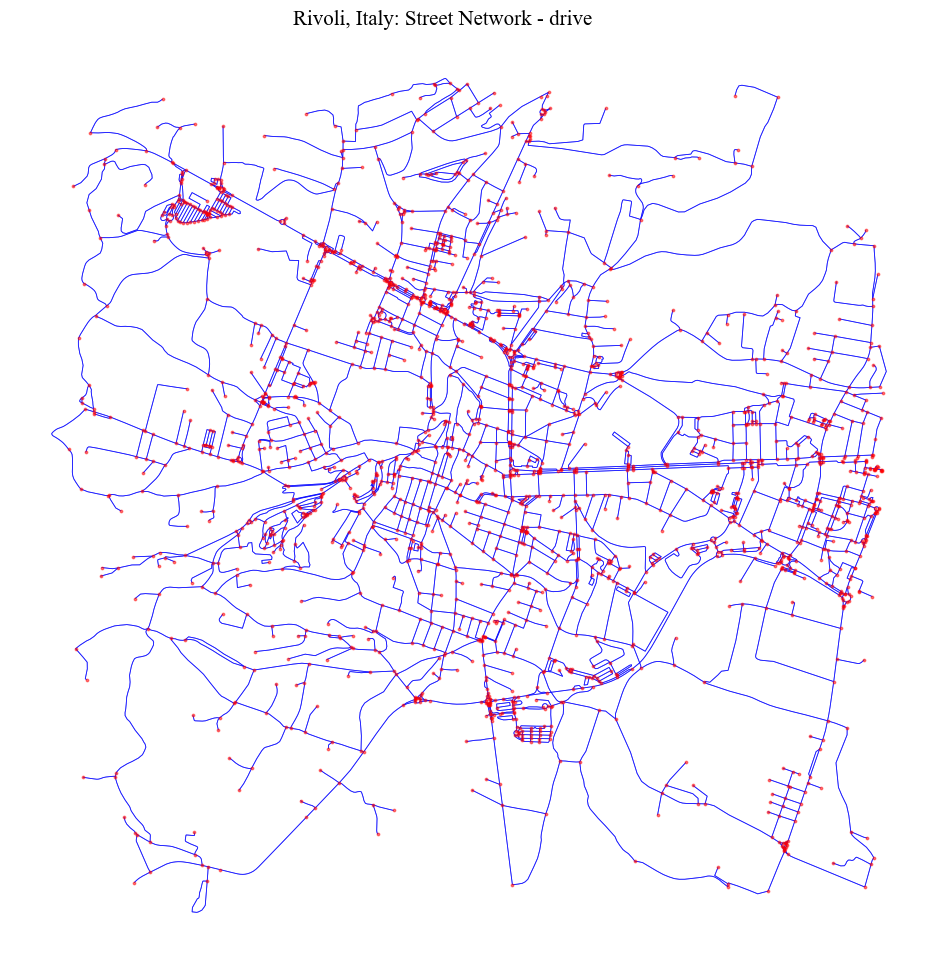

In [4]:
fig = ci.plot_gdf(nodes_graph, black_background = False, figsize = (10,10), title = place+': Street Network - drive',
                  geometry_size = 3, color = 'red', alpha = 0.5, base_map_gdf = edges_graph, base_map_color = 'blue', 
                  base_map_alpha = 0.7, base_map_geometry_size = 0.6)

The `clean` functions handle (through boolean parameters):
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* `remove_islands`: Disconnected islands.
* `dead_ends` Dead-end street segments.
* `self_loops` Self-Loops.
* `same_vertexes_edges` Edges with same from-to nodes, but different geometries.
* `fix_topology` This creates nodes and breaks street segments at intersections. It is primarily useful for poorly formed datasets (usually OSM deerived networks are topologically correct). It accounts for segments classified as bridges or tunnels in OSM.

`same_vertexes_edges` handles edges with same pair of u-v nodes but different geometries. When `True`, it derives a center line between the two segments, unless one of the two segments is longer than the other (>10%). In this case, the shorter segment is deleted.

## Basic Cleaning (Duplicates and Simplification)

In [5]:
nodes_cleaned, edges_cleaned = ci.clean_network(nodes_graph, edges_graph, dead_ends = False, remove_islands = False, 
                                             same_vertexes_edges = False, self_loops = False, fix_topology = False, 
                                             preserve_direction = False, nodes_to_keep_regardless = [])

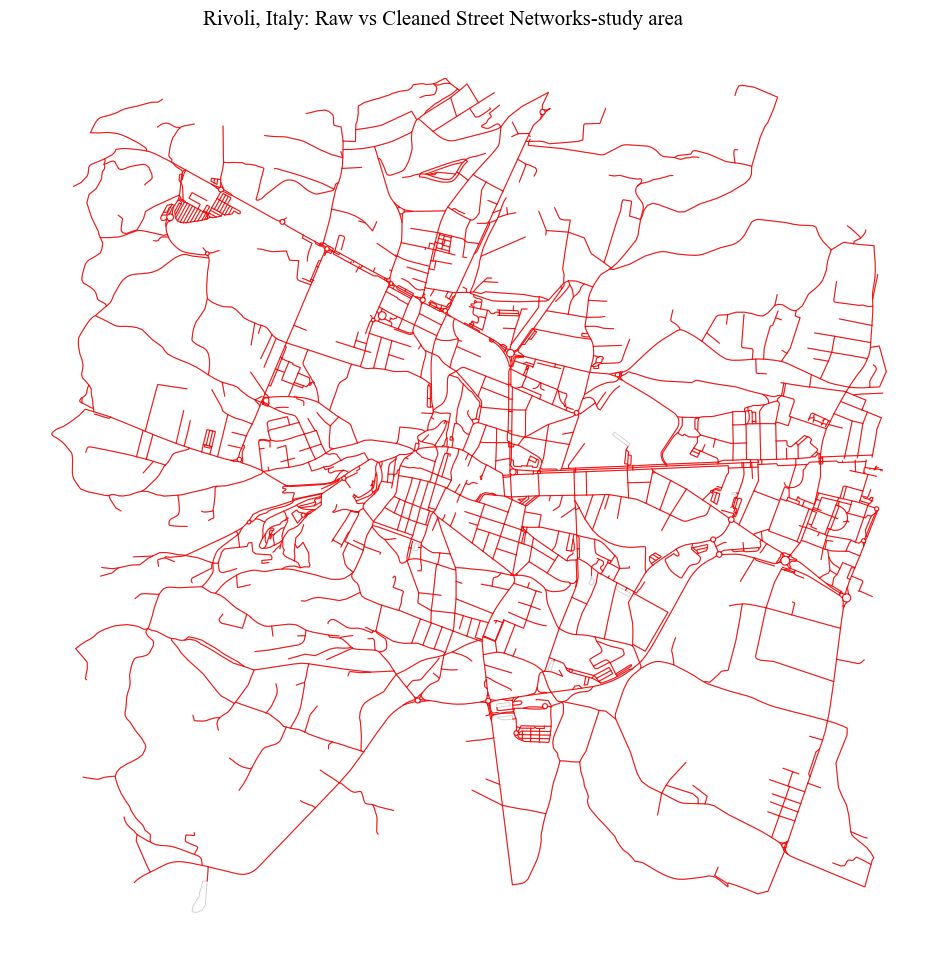

In [6]:
fig = ci.plot_gdf(edges_cleaned, scheme = None,  black_background = False, figsize = (10,10), title = 
              place+': Raw vs Cleaned Street Networks-study area', color = 'red', geometry_size = 0.8, alpha = 0.9,
              base_map_gdf = edges_graph, base_map_color = 'black', base_map_alpha = 0.1, base_map_geometry_size = 0.6)

## Dead-ends and self-loops

In [7]:
nodes_cleaned, edges_cleaned = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = False, 
                                             same_vertexes_edges = False, self_loops = True, fix_topology = False, 
                                             preserve_direction = False, nodes_to_keep_regardless = [])

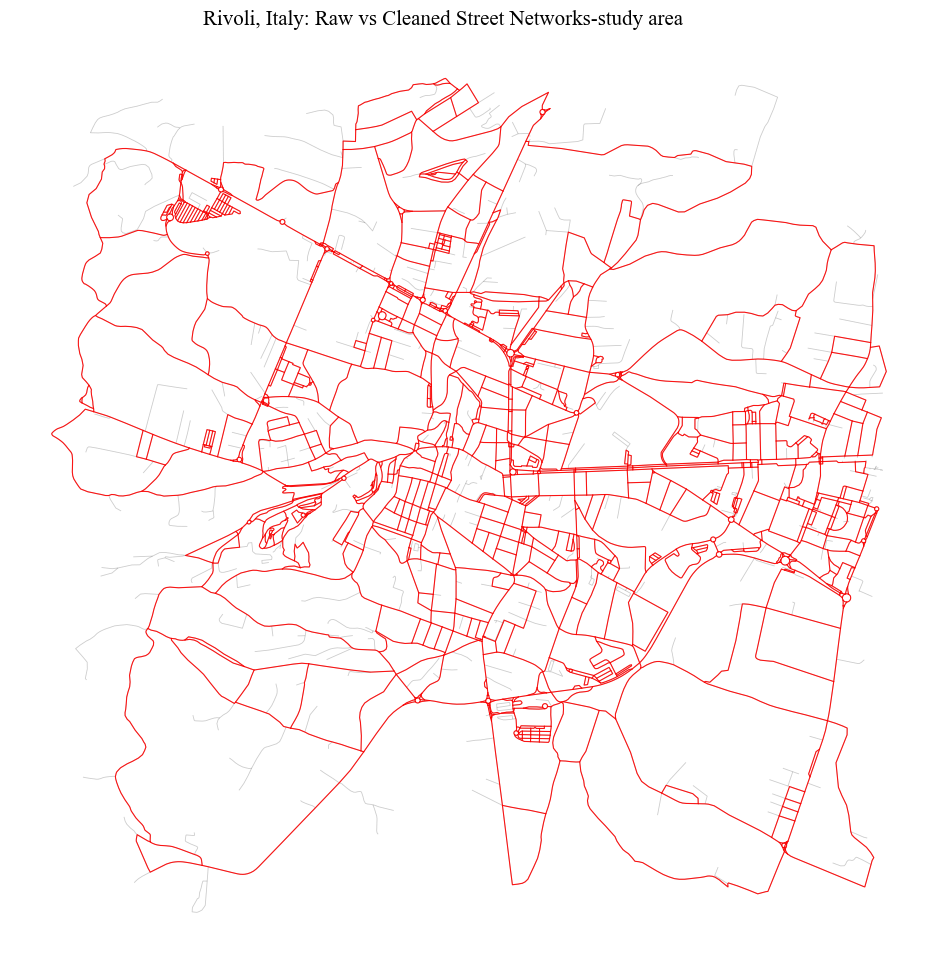

In [10]:
fig = ci.plot_gdf(edges_cleaned, scheme = None,  black_background = False, figsize = (10,10), title = 
              place+': Raw vs Cleaned Street Networks-study area', color = 'red', geometry_size = 0.8, alpha = 0.9,
             base_map_gdf = edges_graph, base_map_color = 'black', base_map_alpha = 0.1, base_map_geometry_size = 0.6)

## Graph Simplification (Removing only pseudo-nodes)

This step cannot be run directly after downloading data from OSM. In fact, OSM represents a street segment with two links. As a consequence, a dead-end junction is confused for a pseudo-node (1 edge x 2 directions = 2 edges), while actual pseudo-nodes are not identified (2 edges x 2 directions = 4).
Therefore, before removing the pseudo-nodes is necessary to remove possible duplicates across the edges.

In [11]:
nodes_cleaned, edges_cleaned = ci.clean_edges(nodes_graph, edges_graph, preserve_direction = False) 

# simplify the graph                           
nodes_cleaned, edges_cleaned = ci.simplify_graph(nodes_cleaned, edges_cleaned, nodes_to_keep_regardless = []) 

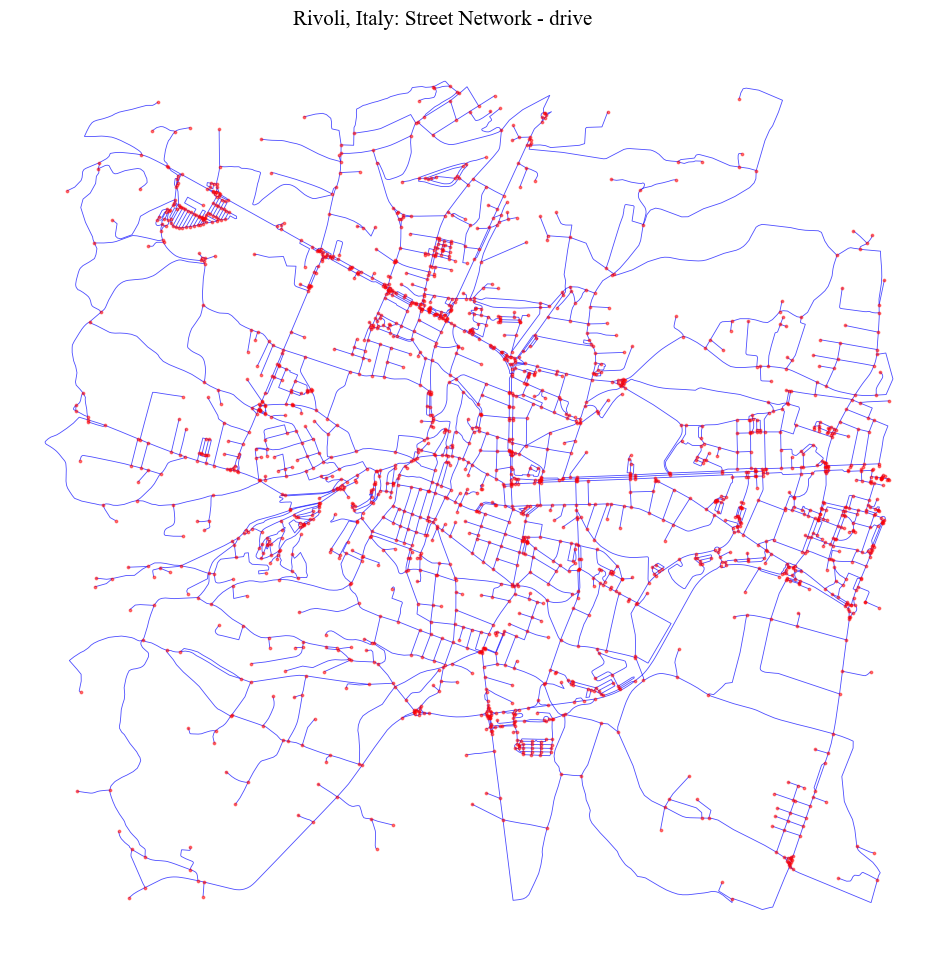

In [12]:
fig = ci.plot_gdf(nodes_cleaned, black_background = False, figsize = (10,10), title = place+': Street Network - drive',
                  geometry_size = 3, color = 'red', alpha = 0.5, base_map_gdf = edges_cleaned, base_map_color = 'blue', 
                  base_map_alpha = 0.7, base_map_geometry_size = 0.6)

## Fixing topology

While the `clean` function performs some checks by default (OSM may present some topological errors at times), when one needs to handle data sources where the geometrical representations of the edges include several mistakes (e.g. edges are not split at intersections), it is advised to perform a full topological check by setting `fix_topology` to `True`. This function can also be run independently `fix_network_topology`.

In [102]:
input_path = '../data/York_street_network.shp'
dict_columns = {"highway": "type", "oneway": "oneway", "lanes" :None, 
            "maxspeed": "maxspeed", "name": "name"}    
epsg_york = 2019
nodes_graph, edges_graph = ci.get_network_fromFile(input_path, epsg_york, dict_columns = dict_columns, other_columns = [])

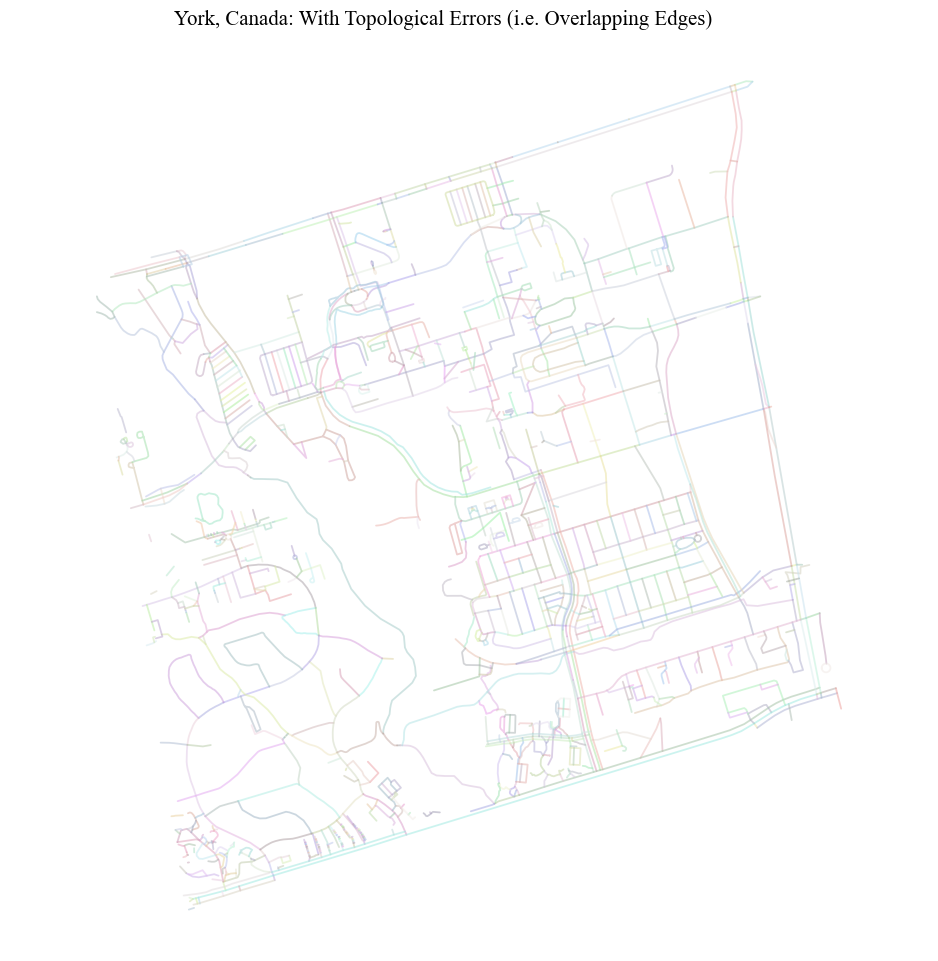

In [103]:
fig = ci.plot_gdf(edges_graph, black_background = False, figsize = (10,10), geometry_size = 1.3, column = 'edgeID',
                 title = "York, Canada: With Topological Errors (i.e. Overlapping Edges)", alpha = 0.5)

In [104]:
nodes_cleaned, edges_cleaned = ci.clean_network(nodes_graph, edges_graph, dead_ends = False, remove_islands = False, 
                                            same_vertexes_edges = False, self_loops = False, fix_topology = True)

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


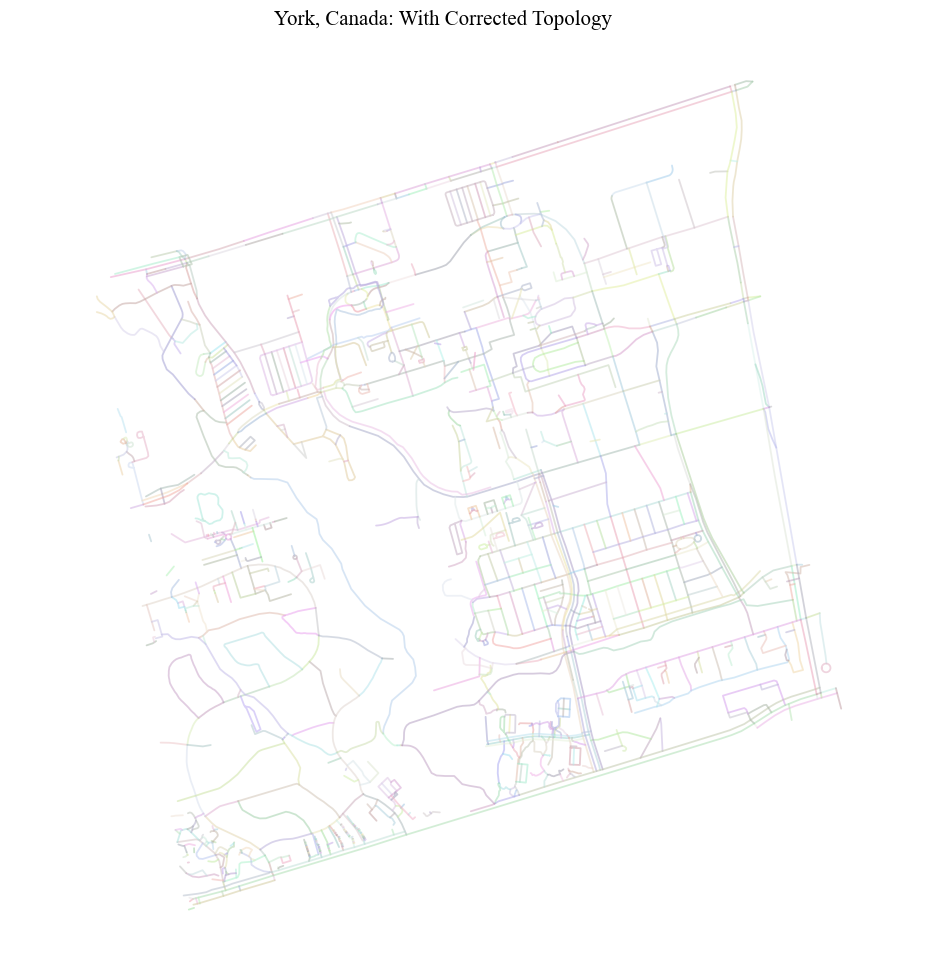

In [105]:
fig = ci.plot_gdf(edges_graph, black_background = False, figsize = (10,10), geometry_size = 1.3, column = 'edgeID',
                 title = "York, Canada: With Corrected Topology", alpha = 0.5)

## Removing disconnected Islands

It may happen that some disconnected set of edges (islands) are included in the representation of the street network. 
This usually includes few segments that can be disregarded. In this example, a tunnel connection between two urban areas is removed to force the creation of a disconnected island.

In [13]:
place = 'Liverpool, UK'
download_method = 'distance_from_address'
distance = 2000
epsg = 27700
nodes_graph, edges_graph = ci.get_network_fromOSM(place = place, download_method = download_method, network_type = 'drive',
                                                  distance = 2000, epsg = epsg)

In [14]:
# basic cleaning
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = False, remove_islands = False, 
                                             same_vertexes_edges = False, self_loops = False, fix_topology = False, 
                                             preserve_direction = False, nodes_to_keep_regardless = [])

In [15]:
# forcing a disconnected Island
edges_graph = edges_graph[edges_graph.tunnel != 1]
nodes_cleaned, edges_cleaned = ci.remove_disconnected_islands(nodes_graph, edges_graph, "nodeID")

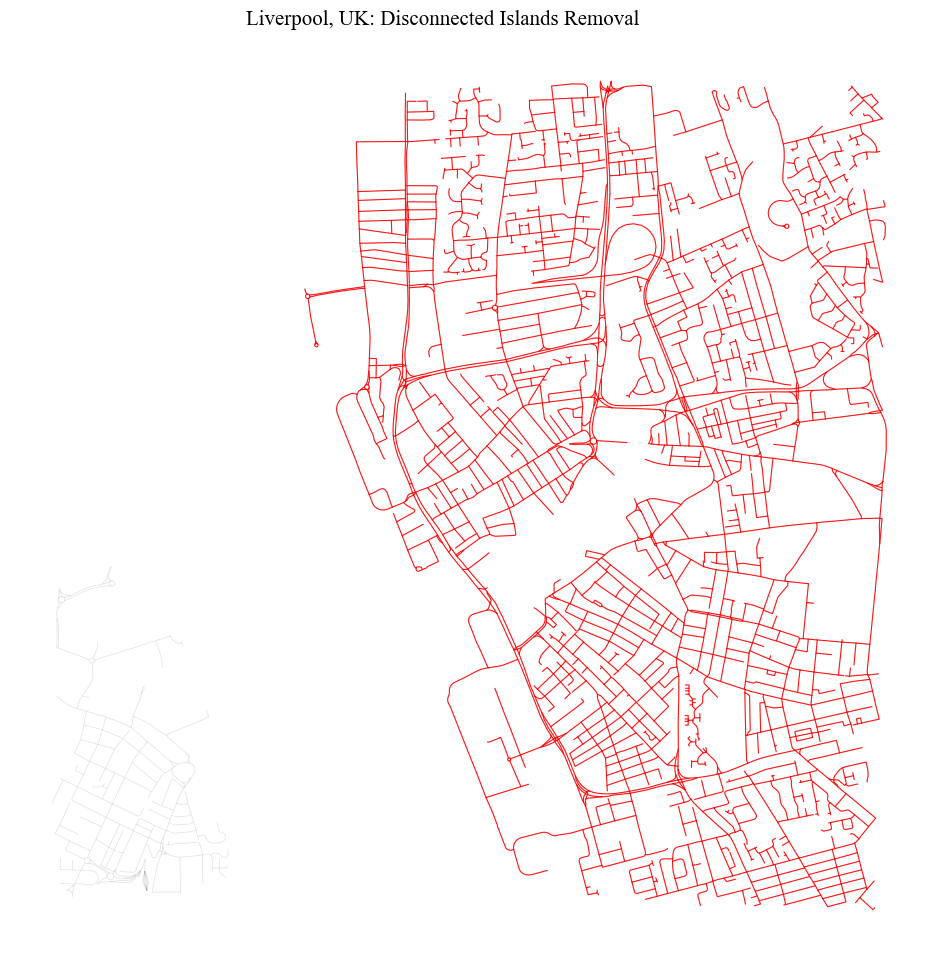

In [16]:
fig = ci.plot_gdf(edges_cleaned, scheme = None,  black_background = False, figsize = (10,10), title = 
              place+': Disconnected Islands Removal', color = 'red', geometry_size = 0.8, alpha = 0.9,
             base_map_gdf = edges_graph, base_map_color = 'black', base_map_alpha = 0.1, base_map_geometry_size = 0.6)